First step in training an R-CNN is to obtain image-level class examples which can be used for training a CNN. This CNN will later be used to extract features from region proposals. First step is to construct training data of individual objects of different size. These images are resized to a predefined size, before they are used to for training a CNN.

NameError: name 'shape' is not defined

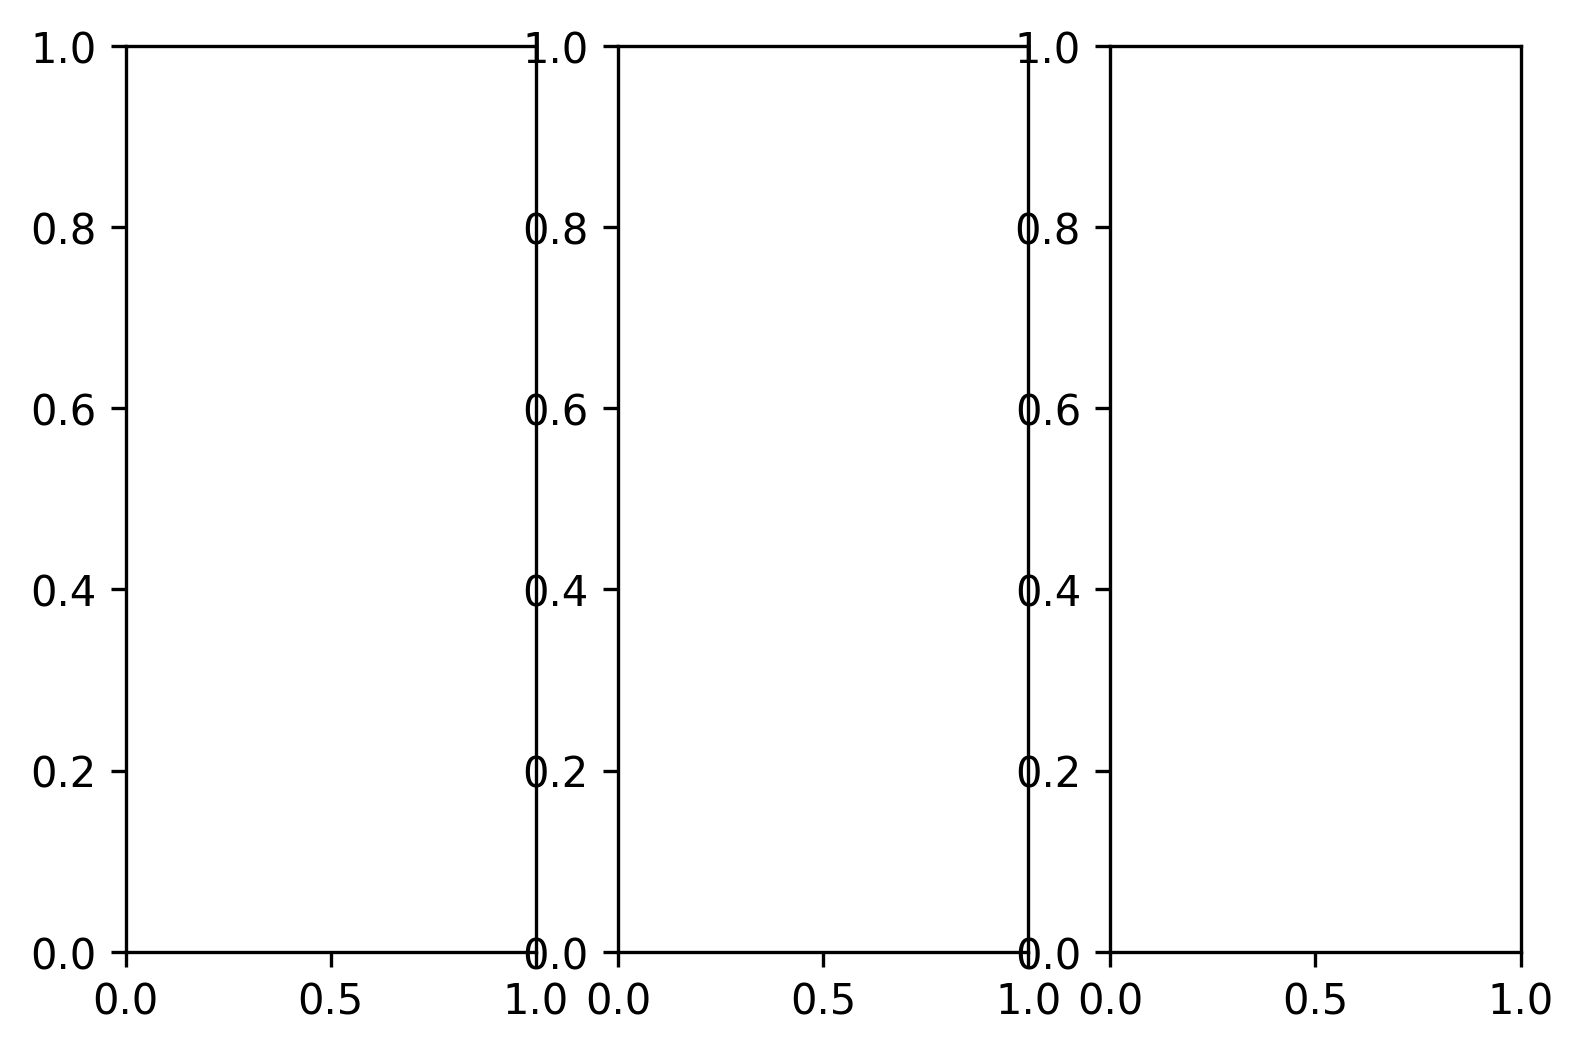

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import minmax_scale
from skimage.segmentation import felzenszwalb
from skimage.segmentation import mark_boundaries
from utils import *

plt.rcParams['figure.dpi'] = 300


# next step: train a network on class example images

fig, axes = plt.subplots(1, 3)
axes[0].imshow(generate_background()); axes[0].axis('off')
axes[1].imshow(generate_square()); axes[1].axis('off')
axes[2].imshow(generate_circle()); axes[2].axis('off')
plt.show()



These images are reshaped to a predefined size

In [ ]:
size = (32, 32)

fig, axes = plt.subplots(1, 3)
axes[0].imshow(tf.image.resize(generate_background(), size)); axes[0].axis('off')
axes[1].imshow(tf.image.resize(generate_square(), size)); axes[1].axis('off')
axes[2].imshow(tf.image.resize(generate_circle(), size)); axes[2].axis('off')
plt.show()


Now we construct a complete training set with n samples from each class

In [ ]:
n = 100

image_set = np.zeros(shape=(3*n, ) + size + (3, ))
image_labels = np.zeros(3*n).astype('int')

for i in range(100):
    image_set[i] = tf.image.resize(generate_background(), size)
    image_labels[i] = 0
    image_set[n + i] = tf.image.resize(generate_square(), size)
    image_labels[n + i] = 1
    image_set[2*n + i] = tf.image.resize(generate_circle(), size)
    image_labels[2*n + i] = 2

idx = np.random.choice(np.arange(3*n), 3*n)

image_set = image_set[idx]
image_labels = image_labels[idx]

fig, axes = plt.subplots(3, 3)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(image_set[i]); ax.axis('off')
    ax.set_title(f'Class {image_labels[i]}')

fig.tight_layout()

Next we construct a CNN and train for say 10 epochs

In [ ]:
epochs = 10

# construct tf.Graph
inputs = tf.keras.layers.Input(shape=size + (3, ))
x = tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

# define model
model = tf.keras.Model(inputs, outputs)

# compile model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy())

model.fit(image_set, image_labels, epochs=epochs)

In [ ]:
test_images = np.zeros(shape=(3*n, ) + size + (3, ))
test_labels = np.zeros(3*n).astype('int')

for i in range(100):
    test_images[i] = tf.image.resize(generate_background(), size)
    test_labels[i] = 0
    test_images[n + i] = tf.image.resize(generate_square(), size)
    test_labels[n + i] = 1
    test_images[2*n + i] = tf.image.resize(generate_circle(), size)
    test_labels[2*n + i] = 2

idx = np.random.choice(np.arange(3*n), 3*n)

test_images = test_images[idx]
test_labels = test_labels[idx]

# print accuracy on test data
print(f'Accuracy: {(np.sum(tf.argmax(model.predict(test_images), axis=1) == test_labels))/(3*n)}')

In [ ]:

# construct an example image with circles and squares
image = SampleImage((128, 128))
image.add_circles(10)
image.add_squares(10)

# display example image along with proposed regions
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(image.pixels, cmap='gray')
ax2.imshow(mark_boundaries(image.pixels, felzenszwalb(image.pixels, scale=1)))
ax1.axis('off')
ax2.axis('off')
plt.show()



Now we have a neural network that is able to adequately discriminate between our classes. Next we need to
1 create an image with several objects in it with known bounding boxes
2 extract region proposals from an image
3 compare each region proposal with the ground truth. If IOU > 0.5 the region proposal is positive for that class. If IoU is < 0.3 for all ground truth bounding boxes, the region is positive for background.
4 Extract features from the proposals using the previously trained network, and use the feature vectors as input to an SVM for each class.
5 Bounding box regression and non-max suppression

In [ ]:
# this is step 1
image = SampleImage((128, 128), 8, 8)
plt.imshow(image)


from utils import SampleImage
import numpy as np
import matplotlib.pyplot as plt
from cv2 import rectangle

test = SampleImage(size=(128, 128), num_circles=10, num_squares=10)

print(test.objects)
plt.imshow(rectangle(test, (0, 0), (10, 10), 3))
plt.show()

In [ ]:
# next step: create tight bounding boxes around region proposals

# tile bounding box proposals
dense_proposals = felzenszwalb(image.pixels)
num_proposals = len(np.unique(dense_proposals)) - 1
proposals = np.zeros(shape=image.shape + (num_proposals, ))

for i in range(num_proposals):
    proposals[:, :, i] = dense_proposals == i + 1

proposals.shape
# match tiled array with constant array of same size
# for all proposals, compute IOU to all true class regions and label them to class if IOU is over 50

#test = np.ones(shape=(3, 4, 5))
#print(test == np.ones_like(test)*0)